## Import libraries

In [2]:
# handling the data manipulations
import pandas as pd

# handling  data computational purposes
import numpy as np

# handling visualisations
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#making beautiful visualizations
import seaborn as sns

# used to access dendograms
import scipy.cluster.hierarchy as shc

# Handling Normalizations
from sklearn.preprocessing import LabelEncoder, StandardScaler

# clustering packages
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

#cluster accuracies
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score

# handling dimension reduction
from sklearn.decomposition import PCA

# removing warnings errors
import warnings
warnings.filterwarnings("ignore")

## Visualization presets

In [4]:
#seaborn presets
sns.set_style('dark', {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize":(15.7, 10.27)})

## Load Data

In [5]:
#load the train_data.csv file from the current folder
df = pd.read_csv("./train_data.csv")

## Preview

In [6]:
df

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


## Column selection

Clustering algorithms are computationally expensive, so it is would be wise to reduce the data size so as to allow the algorithm to converge quickly. If the data is too large, it will take a longer time to converge or it will just shut down the kernel

In [7]:
# frequency of the unique values of Bed Grade and Admission Deposit columns
df[['Bed Grade','Admission_Deposit']].value_counts()

Bed Grade  Admission_Deposit
2.0        4277.0               160
3.0        4469.0               156
2.0        4469.0               150
3.0        4789.0               135
           4624.0               132
                               ... 
2.0        8342.0                 1
           8348.0                 1
           8350.0                 1
           8351.0                 1
1.0        1802.0                 1
Length: 23749, dtype: int64

In [6]:
df.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

Now, i want to see if the first 2000 data points have all the unique values for the Bed Grade column

In [7]:
#checking to see if the Bed Grade column has all its unique values
df.iloc[:2000,:]['Bed Grade'].value_counts()

2.0    952
3.0    612
4.0    251
1.0    183
Name: Bed Grade, dtype: int64

## Cutting out the first 2000 data points to be used for clustering

In [9]:
dfa = df[['Bed Grade','Admission_Deposit']].iloc[:2000,:]

## Check for missing values

In [10]:
dfa.isnull().sum()

Bed Grade            2
Admission_Deposit    0
dtype: int64

## Drop data points with missing values

In [11]:
dfa.dropna(inplace=True)

## Data info

In [12]:
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Bed Grade          1998 non-null   float64
 1   Admission_Deposit  1998 non-null   float64
dtypes: float64(2)
memory usage: 46.8 KB


## Converting the Bed Grade column to an object type (string)

In [13]:
dfa['Bed Grade'] = dfa['Bed Grade'].astype("str")

## Create a copy of the data frame dfa, so that the manipulations done to df1 will not affect dfa

In [18]:
# We call the copy method when we want to create a copy of the data and not mutate the main data
df1 = dfa.copy()

In [19]:
dfa.shape

(1998, 2)

## Normalization

### Categorical value normalization

In [20]:
le = LabelEncoder()
df1['Bed Grade'] = le.fit_transform(df1['Bed Grade'].values)
    
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Bed Grade          1998 non-null   int64  
 1   Admission_Deposit  1998 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.8 KB


In [21]:
df1.describe()

,Bed Grade,Admission_Deposit
count,1998.000000,1998.000000
mean,1.465966,4875.337838
std,0.826812,1050.081196
min,0.000000,2107.000000
25%,1.000000,4173.000000
50%,1.000000,4749.000000
75%,2.000000,5376.750000
max,3.000000,9423.000000


### Numerical values normalization

In [22]:
std = StandardScaler()
df1['Admission_Deposit'] = std.fit_transform(df1['Admission_Deposit'].values.reshape(-1,1))

    
df1.describe()

,Bed Grade,Admission_Deposit
count,1998.000000,1.998000e+03
mean,1.465966,3.485145e-16
std,0.826812,1.000250e+00
min,0.000000,-2.636968e+00
25%,1.000000,-6.690089e-01
50%,1.000000,-1.203426e-01
75%,2.000000,4.776180e-01
max,3.000000,4.331856e+00


In [23]:
df1

,Bed Grade,Admission_Deposit
0,1,0.033970
1,1,1.027475
2,1,-0.124153
3,1,2.282930
4,1,0.650267
...,...,...
1995,1,-2.344537
1996,1,-1.790155
1997,1,2.278168
1998,2,-0.622334


## section out the data to be used

In [25]:
data = df1[['Bed Grade','Admission_Deposit']]

## Dimension reduction

In [26]:
# using PCA with 2 components to transform the data
pca = PCA(2)
df2_pca = pca.fit_transform(data)

## KMeans 2 clusters

In [27]:
km_1 = KMeans(n_clusters = 2, max_iter = 20, verbose = 1).fit(df2_pca)
label = km_1.fit_predict(df2_pca)

Initialization complete
Iteration 0, inertia 3707.575083444565
Iteration 1, inertia 2328.1232859526513
Iteration 2, inertia 2327.507771374078
Iteration 3, inertia 2326.92815762504
Iteration 4, inertia 2325.3135898697656
Iteration 5, inertia 2320.337741746835
Iteration 6, inertia 2304.3949019069473
Iteration 7, inertia 2264.3017203881464
Iteration 8, inertia 2211.9422640098715
Iteration 9, inertia 2179.7042935690847
Iteration 10, inertia 2166.540715511824
Iteration 11, inertia 2159.2285872826883
Iteration 12, inertia 2152.0337058660043
Iteration 13, inertia 2146.696342897115
Iteration 14, inertia 2143.5148869918394
Iteration 15, inertia 2140.34400171208
Iteration 16, inertia 2138.131318266715
Iteration 17, inertia 2136.966073527443
Iteration 18, inertia 2136.049391012777
Iteration 19, inertia 2135.5191967543415
Initialization complete
Iteration 0, inertia 3006.4184862181146
Iteration 1, inertia 2201.39696964621
Iteration 2, inertia 2180.538812176117
Iteration 3, inertia 2163.28364954660

In [31]:
data['2_clusters_km'] = label
dfa['2_clusters_km'] = label

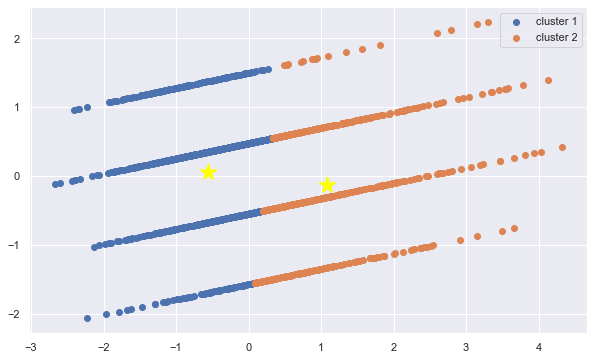

In [32]:
u_labels = np.unique(label)
plt.figure(figsize=(10,6))
# clusters plots
for i in u_labels:
    plt.scatter(df2_pca[label == i, 0], df2_pca[label == i, 1], label = 'cluster {}'.format(1+i))
plt.legend()
# centroid plot
plt.scatter(x = km_1.cluster_centers_[:, [0]],
y = km_1.cluster_centers_[:, [1]],
marker = '*', s = 300, label = 'centroid', c = 'yellow')
plt.show()

In [44]:
dfa[['Bed Grade', '2_clusters_km']].value_counts()

Bed Grade  2_clusters_km
2.0        0                706
3.0        0                353
           1                259
2.0        1                246
1.0        0                164
4.0        1                163
           0                 88
1.0        1                 19
dtype: int64

In the two cluster model, 
- the first cluster has a high proportion of the 2.0 and 3.0 bed grades than the 1.0 and 4.0
- the second cluster has a high proportion of the 3.0 and 2.0, than the 4.0 and 1.0

<AxesSubplot:xlabel='2_clusters_km'>

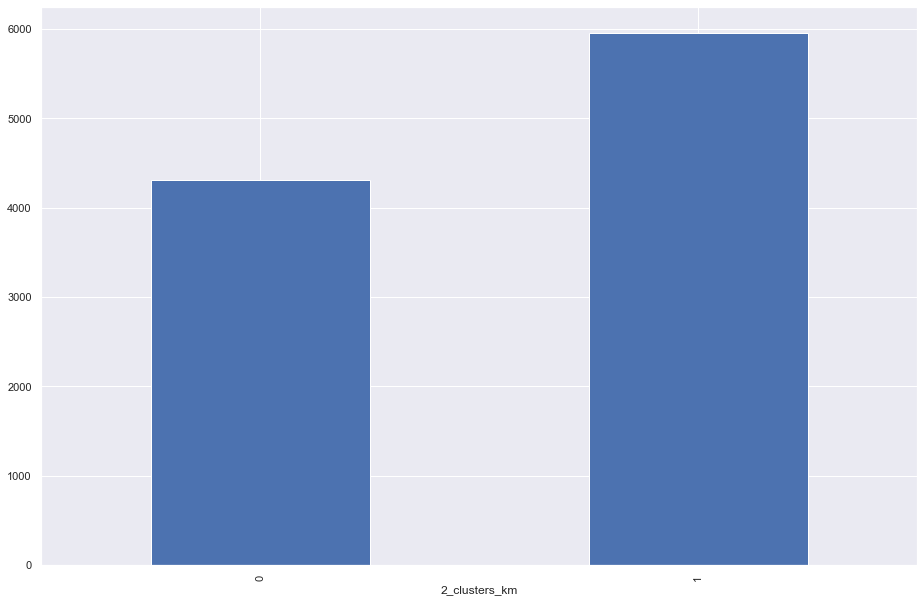

In [60]:
df2 = dfa[['2_clusters_km','Admission_Deposit']]
df2.groupby('2_clusters_km')['Admission_Deposit'].mean().plot(kind='bar')

From the above, the first cluster has an lower average admission deposit than the second one

<AxesSubplot:xlabel='2_clusters_km'>

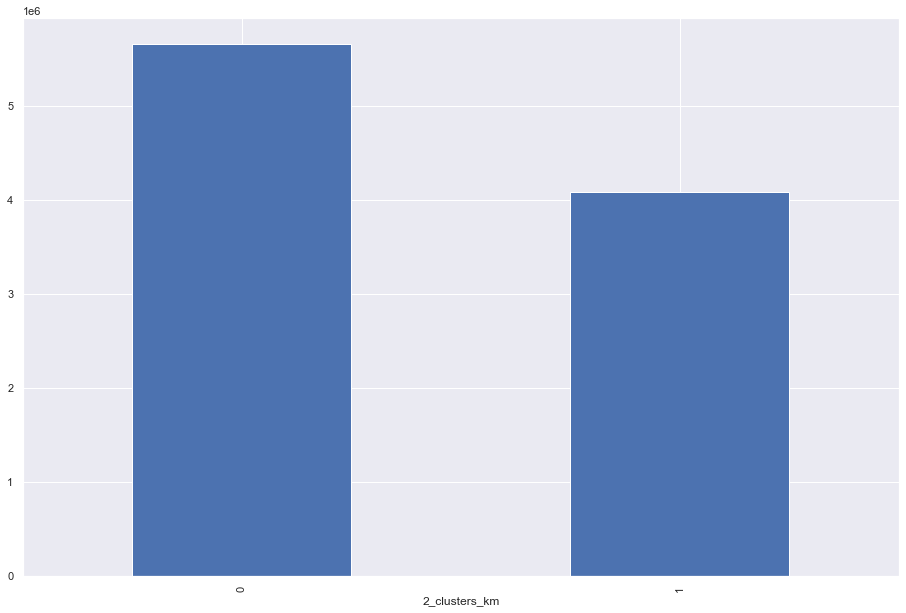

In [61]:
df2.groupby('2_clusters_km')['Admission_Deposit'].sum().plot(kind='bar')

From the above, the first cluster has a higher admission deposit sum than the second cluster

## Conclusion of the 2 clusters

In conclusion, the first cluster contains more of an average class individuals and the second cluster contains extreme conditions, like rich or poor individuals

## KMeans 3 clusters

In [62]:
km_2 = KMeans(n_clusters = 3, max_iter = 20, verbose = 1).fit(df2_pca)
label = km_2.fit_predict(df2_pca)

Initialization complete
Iteration 0, inertia 1736.3768590253721
Iteration 1, inertia 1442.1546537781458
Iteration 2, inertia 1393.677254931185
Iteration 3, inertia 1355.1013992921917
Iteration 4, inertia 1337.895961231371
Iteration 5, inertia 1333.8236231582246
Iteration 6, inertia 1332.3684410644744
Iteration 7, inertia 1332.050388336377
Iteration 8, inertia 1331.82570220743
Converged at iteration 8: center shift 8.25086588846221e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 1748.4562681495615
Iteration 1, inertia 1477.3154465016014
Iteration 2, inertia 1410.3824698100477
Iteration 3, inertia 1371.785484956516
Iteration 4, inertia 1342.1185325462613
Iteration 5, inertia 1333.2962478922004
Iteration 6, inertia 1331.9460331686614
Iteration 7, inertia 1331.764409439092
Converged at iteration 7: center shift 3.710896415904358e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 1853.1307301821748
Iteration 1, i

In [63]:
data['3_clusters_km'] = label
dfa['3_clusters_km'] = label

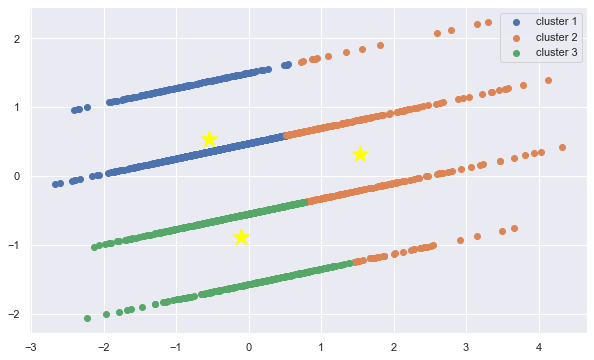

In [64]:
u_labels = np.unique(label)
plt.figure(figsize=(10,6))
# clusters plots
for i in u_labels:
    plt.scatter(df2_pca[label == i, 0], df2_pca[label == i, 1], label = 'cluster {}'.format(1+i))
plt.legend()
# centroid plot
plt.scatter(x = km_2.cluster_centers_[:, [0]],
y = km_2.cluster_centers_[:, [1]],
marker = '*', s = 300, label = 'centroid', c = 'yellow')
plt.show()

In [65]:
dfa[['3_clusters_km','Bed Grade']].value_counts()

3_clusters_km  Bed Grade
0              2.0          757
2              3.0          482
               4.0          216
1              2.0          195
0              1.0          168
1              3.0          130
               4.0           35
               1.0           15
dtype: int64

In the three cluster model,
- we have just 2.0 and 1.0 grade in the first cluster, higher 2.0 proportion
- we have all the grades in the second cluster, higher 2.0 proportion too
- we have just 3.0 and 4.0 in the third cluster, higher 3.0 proportion

<AxesSubplot:xlabel='3_clusters_km'>

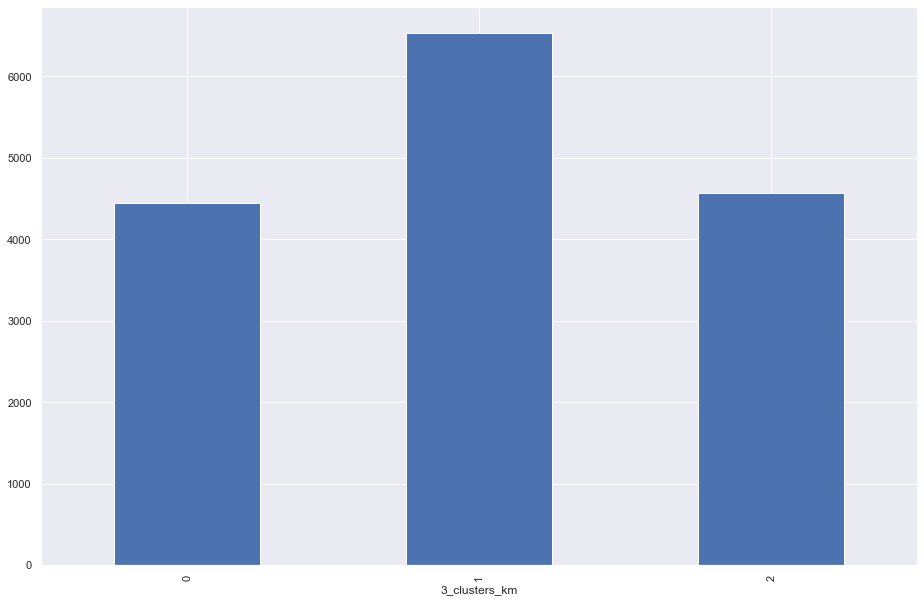

In [66]:
df2 = dfa[['3_clusters_km','Admission_Deposit']]
df2.groupby('3_clusters_km')['Admission_Deposit'].mean().plot(kind='bar')

we have a higher average deposit in the second cluster

<AxesSubplot:xlabel='3_clusters_km'>

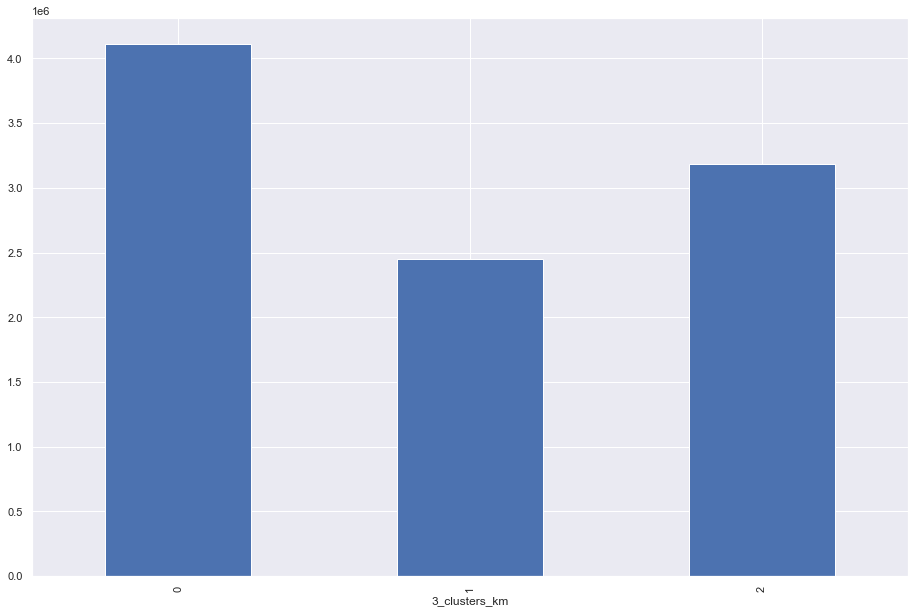

In [67]:
df2.groupby('3_clusters_km')['Admission_Deposit'].sum().plot(kind='bar')

we have a high paid sum in the first cluster

In conclusion, we can divide the clusters into classes of life again, poor, average and rich.
- It would suggest that the middle class paid more on the average.
- The poor got sick the most because of the high sum paid for deposit
- The rich rarely got sick

## The Elbow method

the elbow method is a popular method used for getting the number of optimum clusters when the cluster inertia is plotted against the number of clusters

In [68]:
intertia = []
for i in range(1,12):
    km = KMeans(n_clusters = i, max_iter = 20, verbose = 1).fit(df2_pca)
    intertia.append(km.inertia_)

Initialization complete
Iteration 0, inertia 4506.654437075081.
Iteration 1, inertia 3363.1856856856875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 3823.833554240519.
Iteration 1, inertia 3363.1856856856875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 6824.744753491734.
Iteration 1, inertia 3363.1856856856875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 4961.837303954786.
Iteration 1, inertia 3363.1856856856875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 13482.91365813374.
Iteration 1, inertia 3363.1856856856875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8560.232641141507.
Iteration 1, inertia 3363.1856856856875.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 8392.970799299994.
Iteration 1, inertia 3363.1856

Iteration 6, inertia 1332.0815124861263
Iteration 7, inertia 1331.8610088278629
Iteration 8, inertia 1331.764409439092
Converged at iteration 8: center shift 3.710896415904565e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 1848.9164396197475
Iteration 1, inertia 1509.9111758614395
Iteration 2, inertia 1460.5839437291595
Iteration 3, inertia 1414.4747288095562
Iteration 4, inertia 1376.3055737842378
Iteration 5, inertia 1346.0024846003816
Iteration 6, inertia 1335.0694796772977
Iteration 7, inertia 1332.6920839347843
Iteration 8, inertia 1332.1241317710594
Iteration 9, inertia 1331.8849528893256
Iteration 10, inertia 1331.7853570108878
Converged at iteration 10: center shift 8.332702323697713e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 1515.3269760358462
Iteration 1, inertia 1341.048148481107
Iteration 2, inertia 1333.1396207228988
Iteration 3, inertia 1331.9094375321201
Iteration 4, inertia 1331.7689

Iteration 3, inertia 850.0949525260668
Iteration 4, inertia 845.4785873672055
Iteration 5, inertia 842.509521172912
Iteration 6, inertia 840.7613599529476
Iteration 7, inertia 839.933362476169
Iteration 8, inertia 839.2970982206276
Iteration 9, inertia 839.1079614244179
Iteration 10, inertia 838.9961931357071
Iteration 11, inertia 838.8649929670778
Iteration 12, inertia 838.7922407170452
Converged at iteration 12: center shift 2.3880570762732082e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 1414.9143606121663
Iteration 1, inertia 977.4934579128643
Iteration 2, inertia 907.7520015403952
Iteration 3, inertia 876.7445189825071
Iteration 4, inertia 860.105317050181
Iteration 5, inertia 849.0628291871241
Iteration 6, inertia 845.0929297393556
Iteration 7, inertia 843.2631338547272
Iteration 8, inertia 841.4733020076073
Iteration 9, inertia 840.9770996840388
Iteration 10, inertia 840.7864401750317
Iteration 11, inertia 840.5265878488368
Iteration 12

Iteration 5, inertia 669.2640221044848
Iteration 6, inertia 667.4098762319651
Iteration 7, inertia 666.7248215764288
Iteration 8, inertia 666.3103179267122
Iteration 9, inertia 666.1127583588159
Iteration 10, inertia 666.0121430531323
Iteration 11, inertia 665.8319513158295
Iteration 12, inertia 665.6875421660359
Iteration 13, inertia 665.5943708918137
Iteration 14, inertia 665.489402120626
Iteration 15, inertia 665.4325451461043
Converged at iteration 15: center shift 7.79914812366505e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 759.494895694291
Iteration 1, inertia 673.9288509802259
Iteration 2, inertia 660.4988990958514
Iteration 3, inertia 651.3801228461216
Iteration 4, inertia 646.462746668463
Iteration 5, inertia 640.7511653623786
Iteration 6, inertia 635.0617419792823
Iteration 7, inertia 632.8645138801526
Iteration 8, inertia 632.317884712758
Iteration 9, inertia 631.4733458812044
Iteration 10, inertia 630.4998257263027
Iteration 11, 

Iteration 0, inertia 619.5209929902227
Iteration 1, inertia 491.4649648121151
Iteration 2, inertia 457.80950790640003
Iteration 3, inertia 440.8511572479323
Iteration 4, inertia 435.51754474207763
Iteration 5, inertia 433.04573065741357
Iteration 6, inertia 432.38885574874996
Iteration 7, inertia 432.0840889376047
Iteration 8, inertia 431.8806947159785
Iteration 9, inertia 431.805034847696
Iteration 10, inertia 431.7140816028089
Iteration 11, inertia 431.680572989042
Converged at iteration 11: center shift 1.747476583624595e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 630.1331154820928
Iteration 1, inertia 535.8931519682409
Iteration 2, inertia 522.4564795367774
Iteration 3, inertia 515.2300601639869
Iteration 4, inertia 511.1132861178004
Iteration 5, inertia 508.5021995447823
Iteration 6, inertia 504.22357326896946
Iteration 7, inertia 493.51500089595544
Iteration 8, inertia 483.5255130370296
Iteration 9, inertia 480.94415340987035
Iteration

Initialization complete
Iteration 0, inertia 431.2282882141623
Iteration 1, inertia 389.04820984659017
Iteration 2, inertia 376.68374734519
Iteration 3, inertia 373.16664641321
Iteration 4, inertia 370.57750671067333
Iteration 5, inertia 367.35465603128716
Iteration 6, inertia 364.8610465684181
Iteration 7, inertia 362.44650747782515
Iteration 8, inertia 359.7347423423717
Iteration 9, inertia 352.9243846347603
Iteration 10, inertia 350.4223443020984
Iteration 11, inertia 349.92702661544314
Iteration 12, inertia 349.4356413516476
Iteration 13, inertia 348.89891992157953
Iteration 14, inertia 348.69632792598304
Iteration 15, inertia 348.51137729067506
Iteration 16, inertia 348.2243243491314
Iteration 17, inertia 348.0762502338322
Iteration 18, inertia 348.0200168735036
Iteration 19, inertia 347.98814597232456
Converged at iteration 19: center shift 3.306137123221274e-05 within tolerance 8.416380594809028e-05.
Initialization complete
Iteration 0, inertia 422.12999753648535
Iteration 1, in

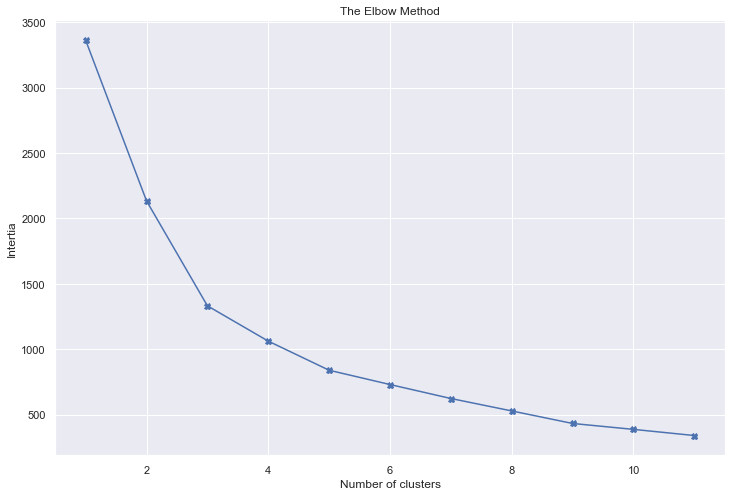

In [69]:
plt.figure(figsize=(12,8))
plt.plot(range(1,12),intertia, marker = 'X')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Intertia")
plt.show()

## Conclusion for elbow method

It shows here that 3 clusters is the optimum number of clusters as there is a bend on the 3 cluster point

## Silhouette analysis

For n_clusters = 2 The average silhouette_score is : 0.36412470751014125
For n_clusters = 3 The average silhouette_score is : 0.4331484301755555
For n_clusters = 4 The average silhouette_score is : 0.39466261903575056
For n_clusters = 5 The average silhouette_score is : 0.39648062947445134
For n_clusters = 6 The average silhouette_score is : 0.42787550800086444


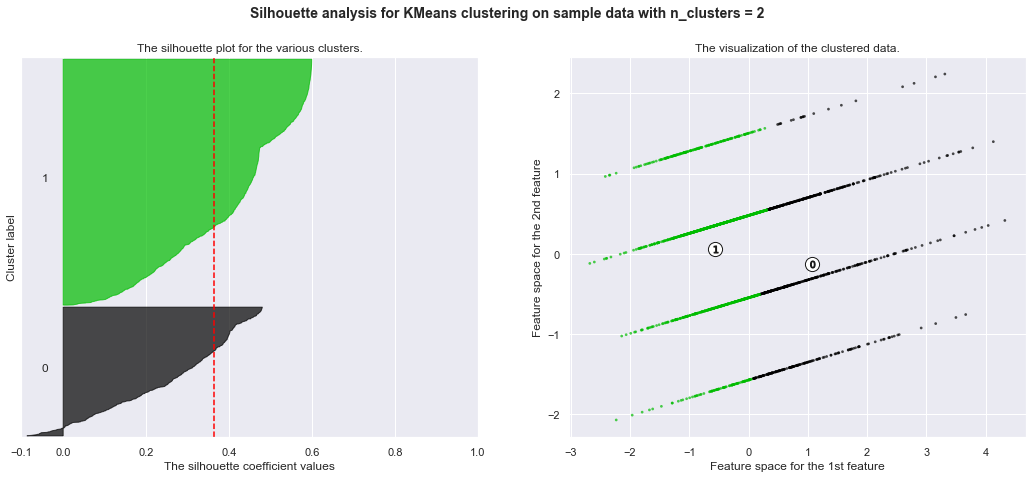

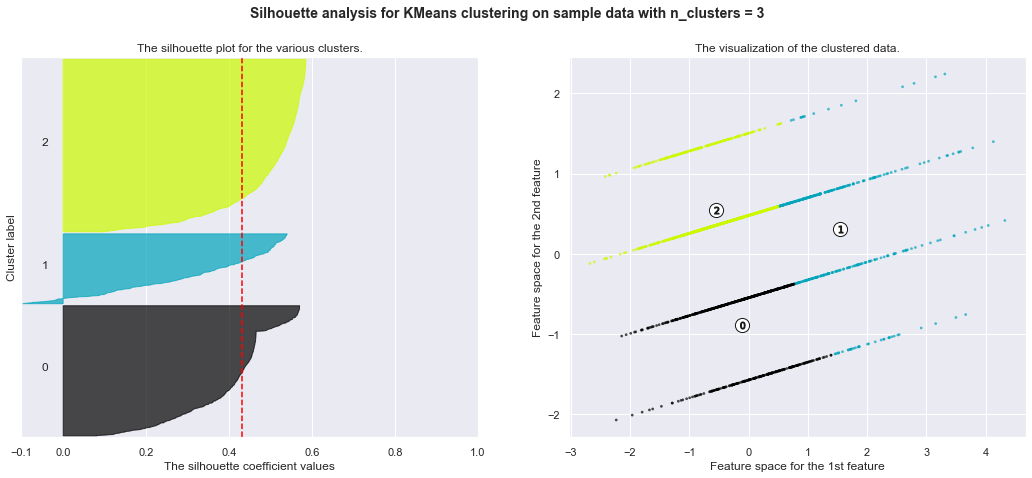

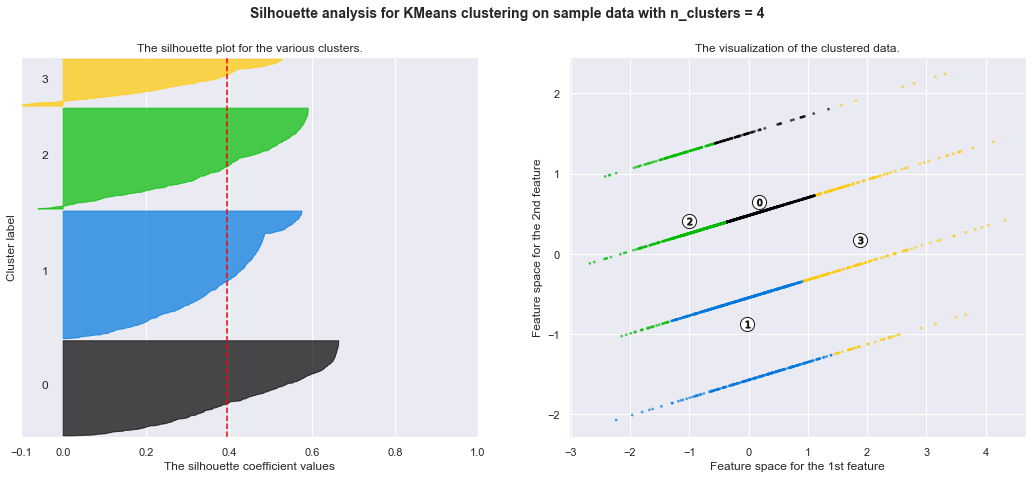

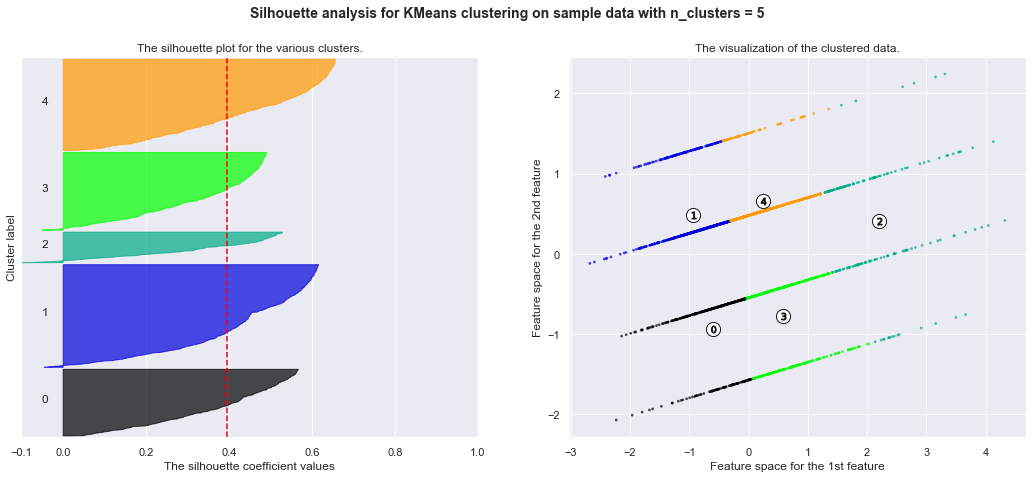

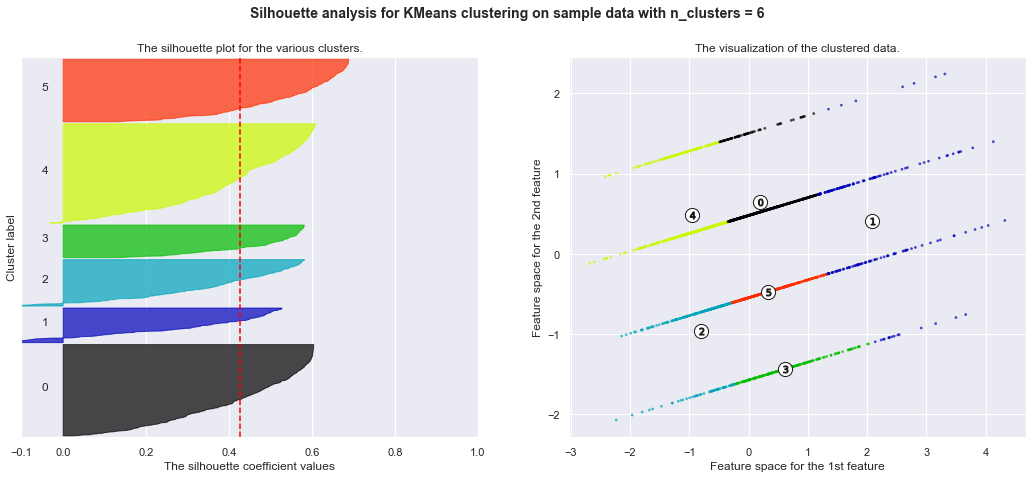

In [70]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df2_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df2_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(df2_pca, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df2_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(df2_pca[:, 0], df2_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## DBSCAN

dbscan is a cluster algorithm and its best known for generating its own number of cluster, we just give the minimum data points to form a cluster and it derives the number of clusters

### DBSCAN Model Training

In [153]:
# initialize the dbscan class
dbscan = DBSCAN(eps=1,min_samples=5)

In [154]:
# fit the data to the model
dbscan.fit(df2_pca)

DBSCAN(eps=1)

### Predictions

In [155]:
df2_pca_df = pd.DataFrame(df2_pca, columns=["x","y"])
df2_pca_df['clusters'] = dbscan.labels_
dfa['dbs_clusters'] = dbscan.labels_

### Visualisations

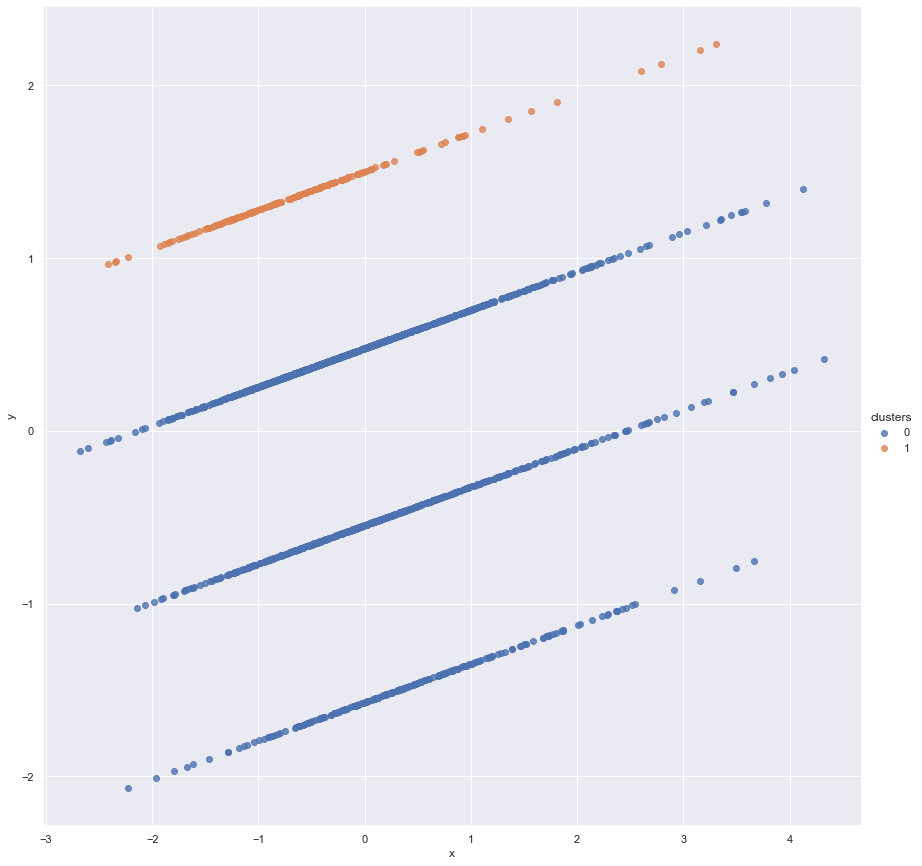

In [156]:
sns.lmplot("x","y", data=df2_pca_df, fit_reg = False, hue="clusters", size=12)

In [157]:
dfa[['dbs_clusters','Bed Grade']].value_counts()

dbs_clusters  Bed Grade
0             2.0          952
              3.0          612
              4.0          251
1             1.0          183
dtype: int64

In the dbscan cluster model,
- the first cluster has the 2.0, 3.0 and 4.0 bed grade 
- the second cluster has just the 1.0 grade

<AxesSubplot:xlabel='dbs_clusters'>

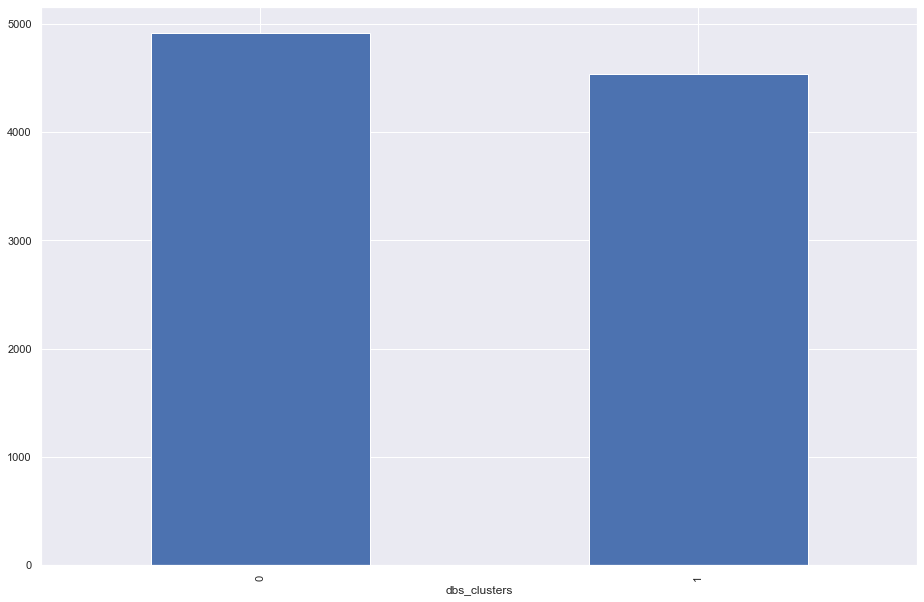

In [158]:
df2 = dfa[['dbs_clusters','Admission_Deposit']]
df2.groupby('dbs_clusters')['Admission_Deposit'].mean().plot(kind='bar')

The average depost for the both clusters are very close with the first cluster edging higher

<AxesSubplot:xlabel='dbs_clusters'>

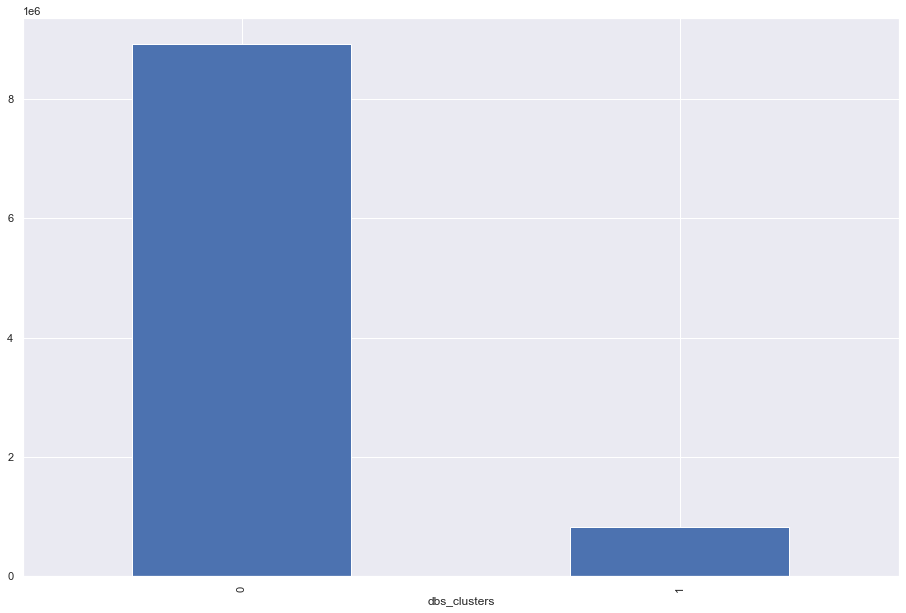

In [159]:
df2.groupby('dbs_clusters')['Admission_Deposit'].sum().plot(kind='bar')

The first cluster paid more deposit in total 

## Conclusion for dbscan

In conclusion, This model is heavily skewed towards the first cluster as it contains more data points so conclusions will be biased 

## Hierarchical clustering

### Dendogram

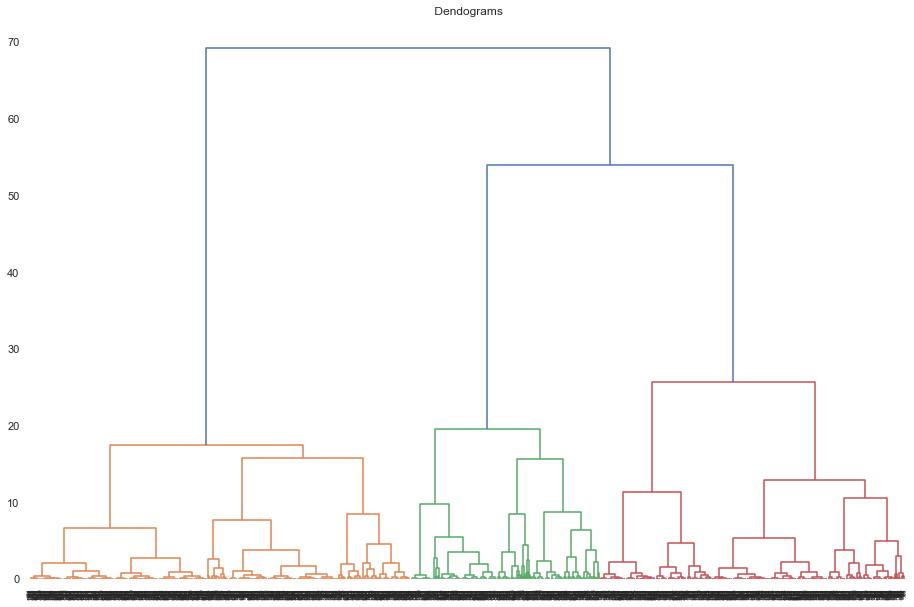

In [161]:
# Plotting a dendogram for the data
plt.title(" Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

From the above, the optimum clusters is three as we can see that for more time, it couldn't be reduced

it stayed as three clusters from 25 to 52, longer than any other cluster

### Agglomerative clustering

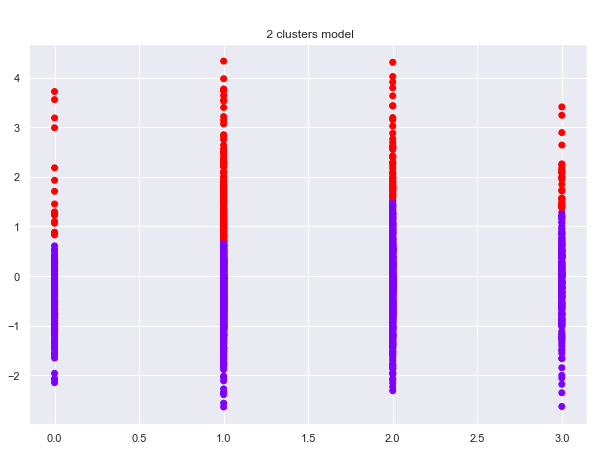

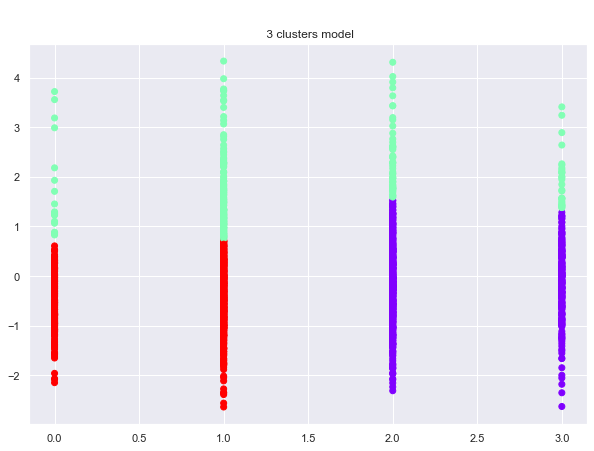

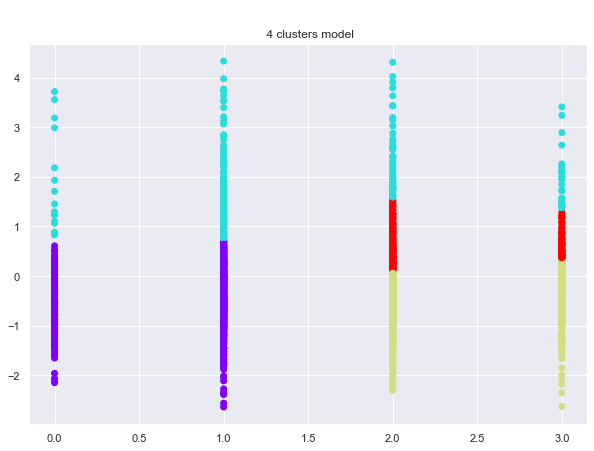

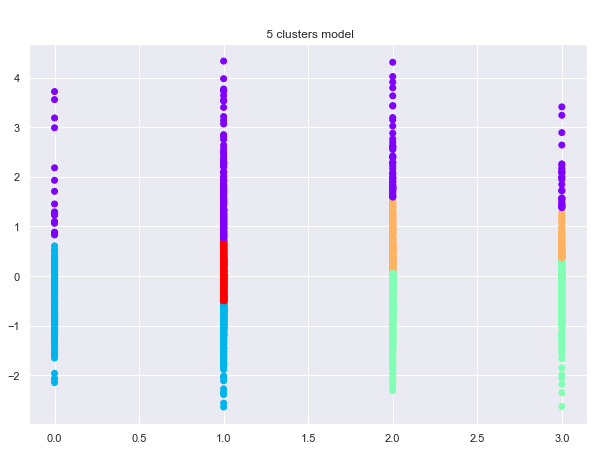

In [164]:
n_cluster = [2,3,4,5]
for n in n_cluster:
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    cluster.fit_predict(df2_pca)
    plt.figure(figsize=(10, 7))
    plt.scatter(data.iloc[:,0], data.iloc[:,1], c=cluster.labels_, cmap='rainbow')
    plt.title("\n\n {} clusters model".format(n))